# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [66]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [3]:
# Your code here
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [4]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1781 non-null   object 
 4   SERVER                     1780 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1781 non-null   object 
 7   WHOIS_STATEPRO             1781 non-null   object 
 8   WHOIS_REGDATE              1781 non-null   object 
 9   WHOIS_UPDATED_DATE         1781 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

After checking each of the columns' values, I will proceed to perform the following operations:

- Drop URL, SERVER and WHOIS_STATEPRO columns, as they will not give any valuable information to our model. 
- CHARSET column: as some of the values are the same, but only differenced by upper and lowercases or other details, I will standardize this in just four different kinds (UTF, ISO, USASCII and WIN)
- WHOIS_REGDATE & WHOIS_UPDATED_DATE: I will convert both columns to datetime; and also in a separate column called UPDATE_FREQ I will store the difference between its last update and the date it was created.
- WHOIS_COUNTRY: some UK values appear as [u'GB'; u'UK'] and United Kingdom. I will set those as UK. Also Cyprus could appear as its abbreviation (CY). After this, I will set all the values to uppercase. 

In [5]:
# Drop columns
websites.drop(labels=['URL', 'WHOIS_STATEPRO'], axis=1, inplace=True)

In [6]:
# Stand. CHARSET column
websites.CHARSET.replace(to_replace={'UTF-8':'UTF', 'utf-8':'UTF', 
                                     'ISO-8859-1':'ISO', 'iso-8859-1':'ISO', 'ISO-8859':'ISO',
                                     'us-ascii':'USASCII',
                                     'windows-1251':'WIN', 'windows-1252':'WIN'}, inplace=True)

In [7]:
# Stand. WHOIS_COUNTRY column
websites.WHOIS_COUNTRY.replace(to_replace={"[u'GB'; u'UK']":'UK', 'United Kingdom':'UK', 
                                           'Cyprus':'CY'}, inplace=True)
websites.WHOIS_COUNTRY = websites.WHOIS_COUNTRY.str.upper()

In [8]:
# Dates to datetime
websites.WHOIS_REGDATE = pd.to_datetime(websites.WHOIS_REGDATE, errors='coerce')
websites.WHOIS_UPDATED_DATE = pd.to_datetime(websites.WHOIS_UPDATED_DATE, errors='coerce')

In [9]:
# Insert UPDATE_FREQ column
websites.insert(loc=7, column='UPDATE_FREQ', value=websites.WHOIS_UPDATED_DATE-websites.WHOIS_REGDATE)
websites.UPDATE_FREQ = websites.UPDATE_FREQ.dt.days

### Predict variable

I can guess the column we want to predict is 'Type', and it says 0 whenever a website is not malicious, and 1 whenever the website is malicious.

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

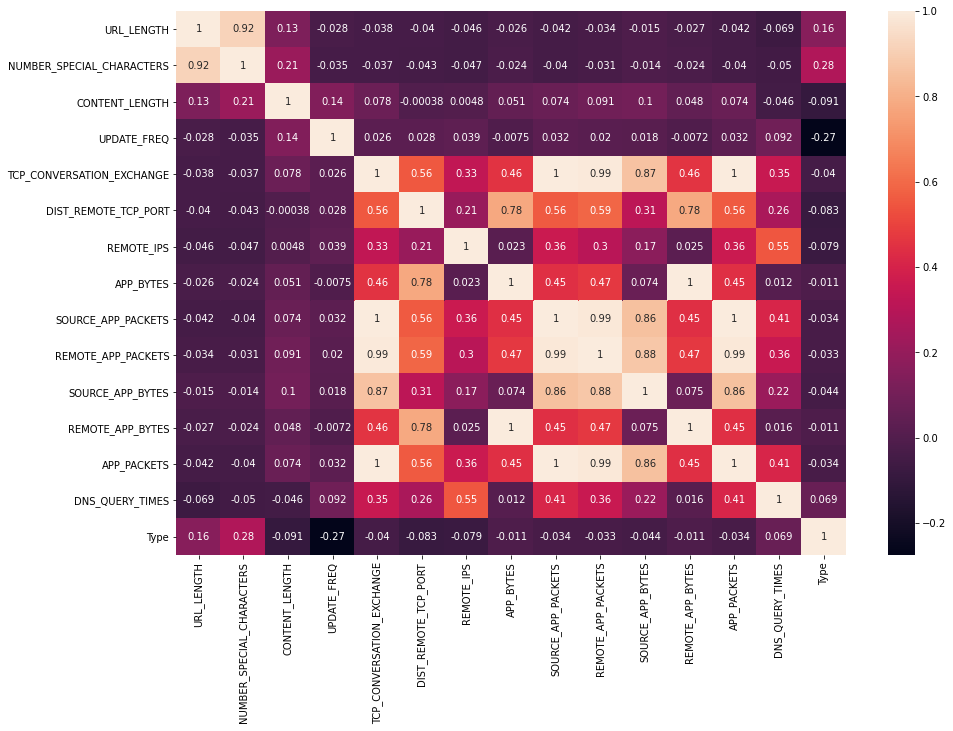

In [10]:
# Your code here
websites_corr = websites.corr()

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(websites_corr, annot=True, ax=ax)
plt.show()

It seems like the highest correlations are given in the columns between TCP_CONVERSATION_EXCHANGE and DNS_QUERY_TIMES, as the colors get clearer for them on the heatmap. Some correlations are even 1, some others are close to it.

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [11]:
websites_corr.mean().sort_values(ascending=False)

APP_PACKETS                  0.470547
SOURCE_APP_PACKETS           0.470547
REMOTE_APP_PACKETS           0.470341
TCP_CONVERSATION_EXCHANGE    0.466200
DIST_REMOTE_TCP_PORT         0.364728
SOURCE_APP_BYTES             0.357084
REMOTE_APP_BYTES             0.313377
APP_BYTES                    0.312670
DNS_QUERY_TIMES              0.238352
REMOTE_IPS                   0.213890
NUMBER_SPECIAL_CHARACTERS    0.135176
CONTENT_LENGTH               0.124602
URL_LENGTH                   0.120133
UPDATE_FREQ                  0.071831
Type                         0.051823
dtype: float64

The first column I will remove is APP_PACKETS, as it has the highest mean correlation with the rest of the columns.

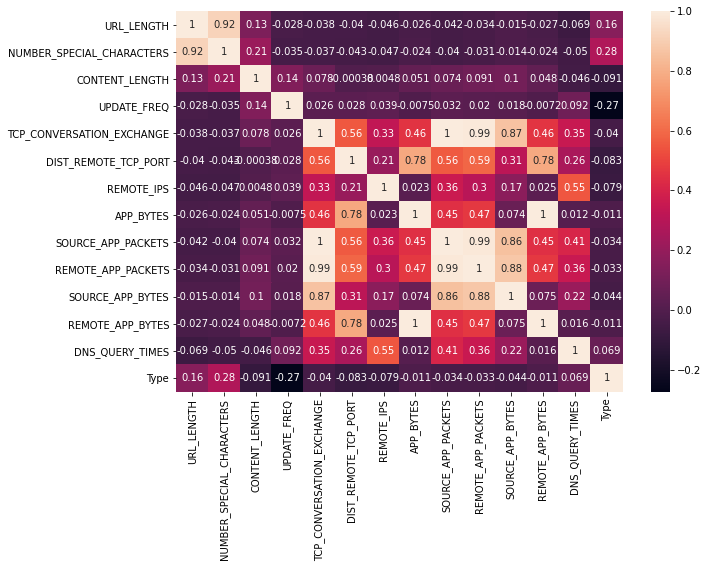

In [12]:
websites_1 = websites.drop(labels=['APP_PACKETS'], axis=1)
websites_corr1 = websites_1.corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(websites_corr1, annot=True, ax=ax)
plt.show()

In [13]:
websites_corr1.mean().sort_values(ascending=False)

REMOTE_APP_PACKETS           0.433274
SOURCE_APP_PACKETS           0.432729
TCP_CONVERSATION_EXCHANGE    0.428229
DIST_REMOTE_TCP_PORT         0.350879
SOURCE_APP_BYTES             0.321340
REMOTE_APP_BYTES             0.303800
APP_BYTES                    0.303159
DNS_QUERY_TIMES              0.226031
REMOTE_IPS                   0.203375
NUMBER_SPECIAL_CHARACTERS    0.147695
URL_LENGTH                   0.131733
CONTENT_LENGTH               0.128207
UPDATE_FREQ                  0.074645
Type                         0.057983
dtype: float64

I will follow the same procedure for the second column to drop, as REMOTE_APP_PACKETS has the highest mean correlation with the rest.

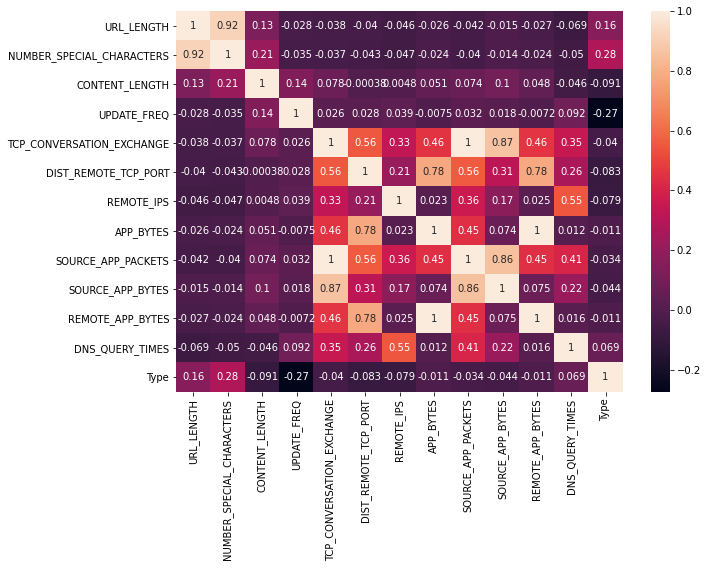

In [14]:
websites_2 = websites_1.drop(labels=['REMOTE_APP_PACKETS'], axis=1)

websites_corr2 = websites_2.corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(websites_corr2, annot=True, ax=ax)
plt.show()

In [15]:
websites_corr2.mean().sort_values(ascending=False)

SOURCE_APP_PACKETS           0.389917
TCP_CONVERSATION_EXCHANGE    0.384951
DIST_REMOTE_TCP_PORT         0.332394
REMOTE_APP_BYTES             0.290985
APP_BYTES                    0.290402
SOURCE_APP_BYTES             0.278324
DNS_QUERY_TIMES              0.216056
REMOTE_IPS                   0.195582
NUMBER_SPECIAL_CHARACTERS    0.161410
URL_LENGTH                   0.144464
CONTENT_LENGTH               0.131063
UPDATE_FREQ                  0.078821
Type                         0.064974
dtype: float64

Same procedure for the next dropping, this time with SOURCE_APP_PACKETS, as it also is one of the columns that has a correlation of 1 with TCP_CONVERSATION_EXCHANGE. 

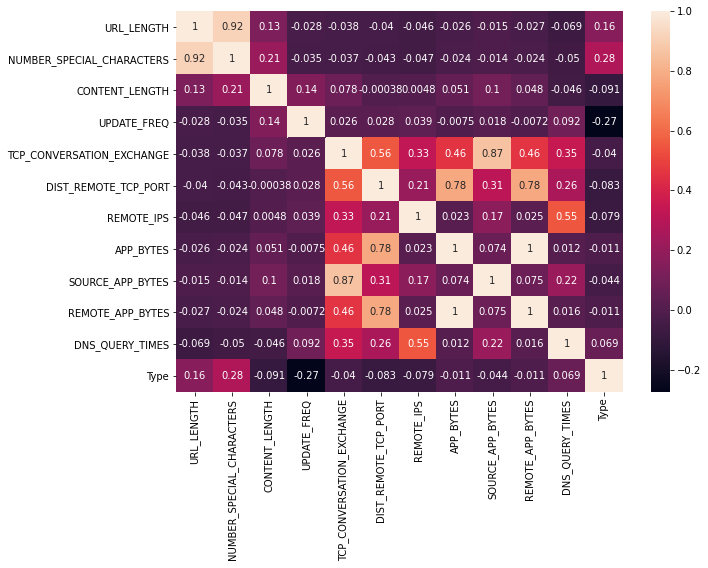

In [16]:
websites_3 = websites_2.drop(labels=['SOURCE_APP_PACKETS'], axis=1)

websites_corr3 = websites_3.corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(websites_corr3, annot=True, ax=ax)
plt.show()

In [17]:
websites_corr3.mean().sort_values(ascending=False)

TCP_CONVERSATION_EXCHANGE    0.333880
DIST_REMOTE_TCP_PORT         0.313542
REMOTE_APP_BYTES             0.277946
APP_BYTES                    0.277450
SOURCE_APP_BYTES             0.230059
DNS_QUERY_TIMES              0.199823
REMOTE_IPS                   0.181788
NUMBER_SPECIAL_CHARACTERS    0.178202
URL_LENGTH                   0.160025
CONTENT_LENGTH               0.135806
UPDATE_FREQ                  0.082686
Type                         0.073256
dtype: float64

It seems like there are just two correlations higher than 0.90 left: APP_BYTES & REMOTE_APP_BYTES, and NUMBER_SPECIAL_CHARACTERS & URL_LENGTH. 

I will follow the same procedure for them, but this time dropping two columns at the same time: REMOTE_APP_BYTES and NUMBER_SPECIAL_CHARACTERS, as both have the highest mean correlations when compared with APP_BYTES and URL_LENGTH respectively.  

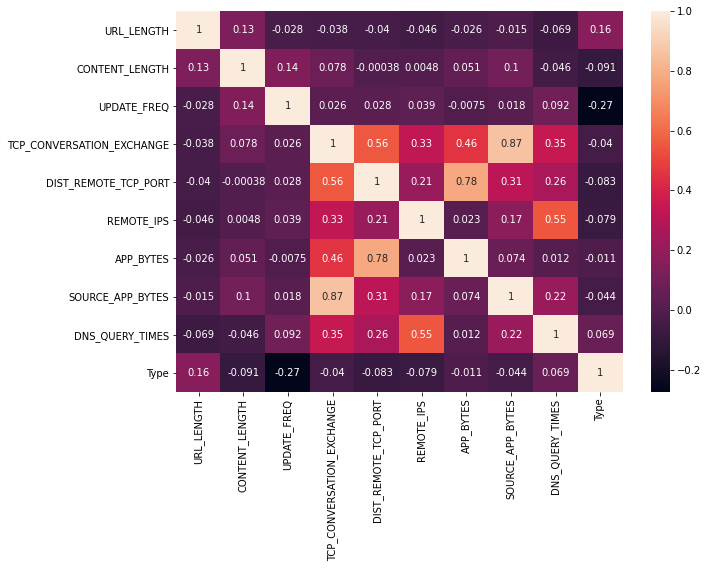

In [109]:
websites_4 = websites_3.drop(labels=['REMOTE_APP_BYTES', 'NUMBER_SPECIAL_CHARACTERS'], axis=1)

websites_corr4 = websites_4.corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(websites_corr4, annot=True, ax=ax)
plt.show()

In [110]:
websites_4.shape

(1781, 15)

After this correlation check, I am left with 14 numerical columns.

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [111]:
# Your code here
websites_4.replace(to_replace=['None', 'NONE'], value=np.nan, inplace=True)
websites_4.isna().sum() / len(websites_4)

URL_LENGTH                   0.000000
CHARSET                      0.003930
SERVER                       0.098821
CONTENT_LENGTH               0.455924
WHOIS_COUNTRY                0.171814
WHOIS_REGDATE                0.072993
UPDATE_FREQ                  0.079169
WHOIS_UPDATED_DATE           0.078046
TCP_CONVERSATION_EXCHANGE    0.000000
DIST_REMOTE_TCP_PORT         0.000000
REMOTE_IPS                   0.000000
APP_BYTES                    0.000000
SOURCE_APP_BYTES             0.000000
DNS_QUERY_TIMES              0.000561
Type                         0.000000
dtype: float64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [112]:
cols_with_nan = websites_4[['CHARSET', 'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE', 'UPDATE_FREQ']]
idx = cols_with_nan.index[cols_with_nan.isnull().all(1)]
len(idx)

0

As there are no rows where all the four columns with any Nan values match, and CONTENT_LENGTH's Nan values mean the more than the 45% of the column, I think the perfect approch will be first to drop that column, and after that drop rows with any Nan value. This will make me lose the least number of rows.

In [113]:
websites_4.drop(labels=['CONTENT_LENGTH'], axis=1, inplace=True)
websites_4.dropna(how='any', inplace=True)
websites_4.reset_index(inplace=True)
websites_4.shape

(1307, 15)

In [114]:
websites_4.isna().sum() / len(websites_4)

index                        0.0
URL_LENGTH                   0.0
CHARSET                      0.0
SERVER                       0.0
WHOIS_COUNTRY                0.0
WHOIS_REGDATE                0.0
UPDATE_FREQ                  0.0
WHOIS_UPDATED_DATE           0.0
TCP_CONVERSATION_EXCHANGE    0.0
DIST_REMOTE_TCP_PORT         0.0
REMOTE_IPS                   0.0
APP_BYTES                    0.0
SOURCE_APP_BYTES             0.0
DNS_QUERY_TIMES              0.0
Type                         0.0
dtype: float64

Now the dataframe is left with 1307 rows and 14 columns without any missing value on it

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [115]:
# Your code here
# JODER, REAL QUE NO HABÍA LEÍDO ESTO ANTES DE HACER LO QUE HE HECHO ARRIBA. CLAVAO :) 

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [116]:
# Your code here
websites_4.WHOIS_COUNTRY.value_counts(dropna=False)

US    960
CA     75
ES     63
AU     34
PA     21
GB     17
UK     15
JP     11
CZ      9
CN      9
IN      8
FR      8
RU      6
CH      6
NL      5
AT      4
SE      4
BS      4
KR      4
PH      4
SC      3
DE      3
TR      3
HK      3
BE      3
KY      3
UA      2
KG      2
IL      2
UY      2
NO      2
SI      2
CY      2
IT      1
LU      1
IE      1
PK      1
UG      1
AE      1
LV      1
BY      1
Name: WHOIS_COUNTRY, dtype: int64

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [117]:
# Your code here
country_counts = websites_4.WHOIS_COUNTRY.value_counts(dropna=False)
to_others = country_counts.index[10:]

In [118]:
others_arr = ['OTHER' if value in to_others else value for index, value in websites_4.WHOIS_COUNTRY.iteritems()] 
websites_4.WHOIS_COUNTRY = pd.Series(others_arr)

In [119]:
websites_4.WHOIS_COUNTRY.value_counts()

US       960
OTHER     93
CA        75
ES        63
AU        34
PA        21
GB        17
UK        15
JP        11
CN         9
CZ         9
Name: WHOIS_COUNTRY, dtype: int64

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [120]:
# Your code here
# WHOIS_STATEPRO ya me la he cargado al principio
websites_4.drop(labels=['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis=1, inplace=True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [121]:
# Your code here
websites_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      1307 non-null   int64  
 1   URL_LENGTH                 1307 non-null   int64  
 2   CHARSET                    1307 non-null   object 
 3   SERVER                     1307 non-null   object 
 4   WHOIS_COUNTRY              1307 non-null   object 
 5   UPDATE_FREQ                1307 non-null   float64
 6   TCP_CONVERSATION_EXCHANGE  1307 non-null   int64  
 7   DIST_REMOTE_TCP_PORT       1307 non-null   int64  
 8   REMOTE_IPS                 1307 non-null   int64  
 9   APP_BYTES                  1307 non-null   int64  
 10  SOURCE_APP_BYTES           1307 non-null   int64  
 11  DNS_QUERY_TIMES            1307 non-null   float64
 12  Type                       1307 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage:

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [122]:
# Your code here
# Hecho al principio

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [123]:
# Your code here
websites_4.CHARSET.value_counts()

UTF        824
ISO        374
USASCII    107
WIN          2
Name: CHARSET, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [124]:
server = websites_4.SERVER.value_counts()
server

Apache                                                                 322
nginx                                                                  147
Microsoft-HTTPAPI/2.0                                                   85
cloudflare-nginx                                                        81
GSE                                                                     49
                                                                      ... 
www.lexisnexis.com  9999                                                 1
Apache/2.2.14 (Unix) mod_ssl/2.2.14 OpenSSL/0.9.8e-fips-rhel5            1
Apache/2.2.11 (Unix) PHP/5.2.6                                           1
MediaFire                                                                1
Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1      1
Name: SERVER, Length: 203, dtype: int64

In [125]:
[index for index, value in server.iteritems() if value >= 10]      

['Apache',
 'nginx',
 'Microsoft-HTTPAPI/2.0',
 'cloudflare-nginx',
 'GSE',
 'Server',
 'Microsoft-IIS/7.5',
 'YouTubeFrontEnd',
 'nginx/1.12.0',
 'ATS',
 'Apache/2.2.15 (CentOS)',
 'Apache-Coyote/1.1',
 'Microsoft-IIS/6.0',
 'Apache/2',
 'Apache/2.2.14 (FreeBSD) mod_ssl/2.2.14 OpenSSL/0.9.8y DAV/2 PHP/5.2.12 with Suhosin-Patch',
 'Apache/2.2.22 (Debian)',
 'Microsoft-IIS/8.5',
 'Apache/2.4.7 (Ubuntu)']

From the values that are repeated 10 times or more, I can see some patterns like Apache servers, Microsoft servers, nginx, GSE or ATS. I will try to apply a lambda function with regex to the column, where for each value it checks whether those words (Apache, Microsoft, nginx) are in the strings. In case they are, that row will be named just with like APACHE, MICROSOFT or NGINX.

In [137]:
websites_4.SERVER = websites_4.SERVER.apply(lambda x: 'APACHE' if re.search('[A-a]pache', x) else 
                                                     ('MICROSOFT' if re.search('[M-m]icrosoft', x) else
                                                     ('NGINX' if re.search('[N-n]ginx', x) else 
                                                     ('CODFW' if re.search('codfw', x) else 
                                                     ('YOUTUBE' if re.search('YouTube', x) else 'OTHER')))))      
websites_4.SERVER.value_counts()

APACHE       516
NGINX        330
OTHER        205
MICROSOFT    154
CODFW         61
YOUTUBE       41
Name: SERVER, dtype: int64

After running the lambda for the three kinds I though were more common in the column I discovered few more like CODFW or YOUTUBE, with a name of occurences I estimated important to add. This way, I just leave the kind OTHER with just 205 values.

![Think Hard](../think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [35]:
# Your code here


In [138]:
# Count `SERVER` value counts here
websites_4.SERVER.value_counts()

APACHE       516
NGINX        330
OTHER        205
MICROSOFT    154
CODFW         61
YOUTUBE       41
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [144]:
websites_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      1307 non-null   int64  
 1   URL_LENGTH                 1307 non-null   int64  
 2   CHARSET                    1307 non-null   object 
 3   SERVER                     1307 non-null   object 
 4   WHOIS_COUNTRY              1307 non-null   object 
 5   UPDATE_FREQ                1307 non-null   float64
 6   TCP_CONVERSATION_EXCHANGE  1307 non-null   int64  
 7   DIST_REMOTE_TCP_PORT       1307 non-null   int64  
 8   REMOTE_IPS                 1307 non-null   int64  
 9   APP_BYTES                  1307 non-null   int64  
 10  SOURCE_APP_BYTES           1307 non-null   int64  
 11  DNS_QUERY_TIMES            1307 non-null   float64
 12  Type                       1307 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage:

In [145]:
# Your code here
website_dummy = pd.get_dummies(websites_4, columns=['CHARSET', 'SERVER', 'WHOIS_COUNTRY'], drop_first=True)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [146]:
# Your code here
website_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      1307 non-null   int64  
 1   URL_LENGTH                 1307 non-null   int64  
 2   UPDATE_FREQ                1307 non-null   float64
 3   TCP_CONVERSATION_EXCHANGE  1307 non-null   int64  
 4   DIST_REMOTE_TCP_PORT       1307 non-null   int64  
 5   REMOTE_IPS                 1307 non-null   int64  
 6   APP_BYTES                  1307 non-null   int64  
 7   SOURCE_APP_BYTES           1307 non-null   int64  
 8   DNS_QUERY_TIMES            1307 non-null   float64
 9   Type                       1307 non-null   int64  
 10  CHARSET_USASCII            1307 non-null   uint8  
 11  CHARSET_UTF                1307 non-null   uint8  
 12  CHARSET_WIN                1307 non-null   uint8  
 13  SERVER_CODFW               1307 non-null   uint8

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [153]:
from sklearn.model_selection import train_test_split

# Your code here:
X_website = website_dummy.drop(labels=['Type', 'index'], axis=1)
y_website = website_dummy.Type
X_train, X_test, y_train, y_test = train_test_split(X_website, y_website, test_size=0.2, random_state=42)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [154]:
# Your code here:
from sklearn.linear_model import LogisticRegression

website_mod = LogisticRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [155]:
# Your code here:
website_mod_fit = website_mod.fit(X_train, y_train)

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [156]:
# Your code here:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = website_mod_fit.predict(X_test)

In [159]:
y_test.value_counts()

0    229
1     33
Name: Type, dtype: int64

In [160]:
conf_mtrx = confusion_matrix(y_test, y_pred)
pd.DataFrame(conf_mtrx)

,0,1
0,223,6
1,17,16


In [158]:
accuracy_score(y_test, y_pred)

0.9122137404580153

What are your thoughts on the performance of the model? Write your conclusions below.

We can say this model perfroms really good, as it has predicted right the 91% of the test results which has been compared with.

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [161]:
# Your code here:
from sklearn.neighbors import KNeighborsClassifier

website_mod_n = KNeighborsClassifier(n_neighbors=3)
website_mod_n.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [162]:
# Your code here:
y_pred_n = website_mod_n.predict(X_test)

In [163]:
conf_mtrx_n = confusion_matrix(y_test, y_pred_n)
pd.DataFrame(conf_mtrx_n)

,0,1
0,226,3
1,11,22


In [165]:
accuracy_score(y_test, y_pred_n)

0.9465648854961832

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [166]:
# Your code here:
website_mod_n5 = KNeighborsClassifier(n_neighbors=5)
website_mod_n5.fit(X_train, y_train)

y_pred_n5 = website_mod_n5.predict(X_test)

conf_mtrx_n5 = confusion_matrix(y_test, y_pred_n5)
pd.DataFrame(conf_mtrx_n5)

,0,1
0,229,0
1,11,22


In [167]:
accuracy_score(y_test, y_pred_n5)

0.9580152671755725

Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

The model that performs definitely much better than the other is the K-Nearest Neighbors model with k=5, is it predicted right nearly the 96% of our test results. The K-Nearest Neighbors model with k=3 is also a good model, so we can say that K-Nearest Neighbors models, in general, work better for our dataset.

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [48]:
# Your code here